![image.png](attachment:image.png)

# Single-qubit geometric gates

In this notebook we create a single-qubit geometric gate between the ground and the second excited state of a transmon by simultaneously driving the $|0\rangle$ to $|1\rangle$ and the $|1\rangle$ to $|2\rangle$ transitions. The pulses that drive each transition must have the same envelope. The shape of the Xp-pulse of the $|0\rangle$ to $|1\rangle$ transition is stored in the configuration of the backend. The Xp-pulse of the $|1\rangle$ to $|2\rangle$ transition is not stored in this configuration. We must therefor calibrate it. This is done in two steps:

1. We identify the frequency of the $|1\rangle$ to $|2\rangle$ transition using spectroscopy.
2. We identify the amplitude of the Xp-pulse between the $|1\rangle$ to $|2\rangle$ transition.

Once these steps are done we will build a discriminator to discriminate the $|0\rangle$, $|1\rangle$, and $|2\rangle$. Once this is done we finally have the tools required to implement and measure a single-qubit geometric gate.

References:
- Abdumalikov *et al.*, Nature **496**, 482-485 (2013)
- Egger *et al*, Phys. Rev. Applied **11**, 014017 (2019)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit.pulse as pulse
from qiskit.compiler import assemble

# Qiskit pulse
from qiskit.pulse import (MemorySlot, Acquire, DriveChannel, Schedule, SamplePulse, 
                          InstructionScheduleMap, Play, MeasureChannel, AcquireChannel)
from qiskit.pulse.pulse_lib import Gaussian
from qiskit.qobj.utils import MeasLevel, MeasReturnType
from qiskit.scheduler import measure_all
from qiskit.visualization.pulse.qcstyle import SchedStyle

# Ignis discriminator fitter tools
from sklearn.svm import SVC
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, MeasurementFilter
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
from qiskit.ignis.measurement.discriminator.iq_discriminators import SklearnIQDiscriminator

%matplotlib inline

### Load a high resolution pulse backend

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='dev-qiskit', project='pulse-testing')
backend = provider.get_backend('ibmq_armonk')

In [3]:
backend

<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-internal', group='dev-qiskit', project='pulse-testing')>

In [4]:
config = backend.configuration()
defaults = backend.defaults()
inst_map = defaults.circuit_instruction_map
style = SchedStyle(figsize=(16, 5))  # schedule style plotting

Extract the default Xp and measurement pulse for the qubit that we are going to use.

In [5]:
xp = inst_map.get('x', (0,)).instructions[0][1].pulse
d0 = DriveChannel(0)
dt = config.dt
shots = 1024

In [6]:
def add_modulation(pulse, freq: float, dt: float, scale: float = 1.) -> SamplePulse:
    """
    Add a modulation to the pulse.
    
    Args:
        samples: A list of AWG samples to modulate.
        freq: The frequency of the modulation to add to samples.
        dt: The cycle time.
        scale: a factor to scale the samples.
        
    Returns: SamplePulse with the added modulation.
    """
    
    if not isinstance(pulse, SamplePulse):
        samples = pulse.get_sample_pulse().samples
    else:
        samples = pulse.samples
    
    modulated_samples = []
    for i, amp in enumerate(samples):
        modulated_samples.append(scale * amp * np.exp(-2.0j*np.pi*freq*i*dt))
    
    return SamplePulse(modulated_samples)

def get_job_data(job, average: bool, qubit: int, scale_factor=1):
    """Retrieve data from a job that has already run.
    
    Args:
        job (Job): The job whose data you want.
        average: If True, gets the data assuming data is an average.
                 If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def lorenz(x, a, q_freq, b, c):
     return (a / np.pi) * (b / ((x - q_freq)**2 + b**2)) + c

## Calibration of an X gate between $|1\rangle$ and $|2\rangle$

### Find the $|1\rangle$ to $|2\rangle$ transition

We use spectroscopy to find the transition between $|1\rangle$ and $|2\rangle$.
First, we apply a pi-pulse to the qubit to prepare the $|1\rangle$ state.
Next, we apply a longer and weaker spectroscopic pulse with a frequency detunning $\delta f$ from the $|0\rangle$ to $|1\rangle$ transition and measure.
By repeating this experiment for different values of $\delta f$ we can identify the frequency detunning of the transition between $|1\rangle$ and $|2\rangle$ which is called the anharmonicity $\alpha$.

In [7]:
exps = 74
frequency_offsets = np.linspace(-0.41, -0.39, exps)  # Frequency range to scan in GHz

schedules = []
for freq in frequency_offsets:
    sched = Schedule(name='Frequency %f MHz' % (freq/1e3))
    
    spec_pulse = add_modulation(Gaussian(1600, 0.3, 320), freq*1e9, dt)
        
    sched += Play(xp, d0)
    sched += Play(spec_pulse, d0)
    sched += measure_all(backend) << sched.duration
    
    schedules.append(sched)

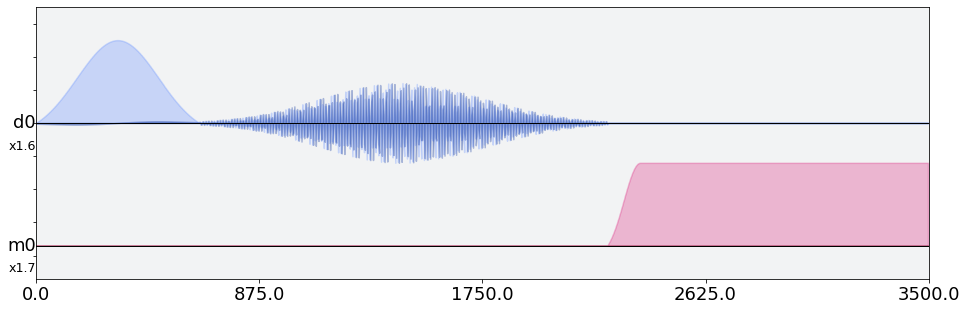

In [8]:
schedules[32].draw(plot_range=[0, 3500], style=style, channels=[DriveChannel(0), MeasureChannel(0)])

In [9]:
qobj = assemble(schedules, backend, meas_level=1, 
                meas_return=MeasReturnType.AVERAGE,
                shots=shots)

In [10]:
job = backend.run(qobj)
job.job_id()

'5e87315a0cbcf10018e438b4'

In [11]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [13]:
result = get_job_data(job, True, 0, 1e-15)
signal = abs(np.array(result))
signal = np.average(signal)-signal

In [14]:
popt, pcov = curve_fit(lorenz, frequency_offsets, signal, [0.015, -0.398, 0.0045, 0.1])
anharmonicity = popt[1]*1e9

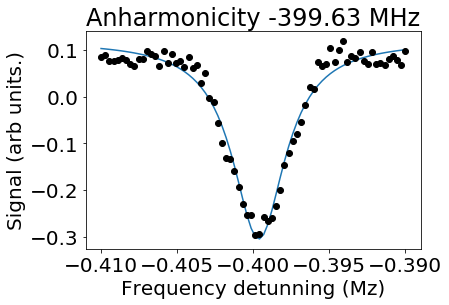

In [15]:
fig = plt.figure()
plt.rcParams['font.size'] = 20
plt.plot(frequency_offsets, [lorenz(_, *popt) for _ in frequency_offsets])
plt.plot(frequency_offsets, signal, 'ok')
plt.xlabel('Frequency detunning (Mz)')
plt.ylabel('Signal (arb units.)')
plt.title('Anharmonicity %.2f MHz' % (anharmonicity/1e6));

## Calibrate a $\pi$-pulse between 1 and 2

Since we now know the anharmonicity $\alpha$ of the transmon, we can apply a freqeuancy modulation $e^{i\alpha t}$ to the pulse envelope $\Omega(t)$ that implements an $X$ gate between $|0\rangle$ and $|1\rangle$ to drive the $|1\rangle$ to $|2\rangle$ transition. 
However, the resulting pulse will not have the correct amplitude to implement a $\pi$-pulse between $|1\rangle$ and $|2\rangle$.
To calibrate this pulse we scan a scaling factor $\eta$ of the pulse envelope $\eta\,\Omega(t)\,e^{i\alpha t}$ to measure a Rabi oscillation between $|1\rangle$ and $|2\rangle$.

In [16]:
xp12_scales = np.linspace(0., 1.6, 74)

schedules = []
for amp in xp12_scales:
    sched = Schedule(name='Amplitude {:.3f} (\\% AWG output)'.format(amp))
    
    xp12 = add_modulation(xp, anharmonicity, dt, scale=amp)
    
    sched += Play(xp, d0)
    sched += Play(xp12, d0)
    sched += measure_all(backend) << sched.duration
    
    schedules.append(sched)

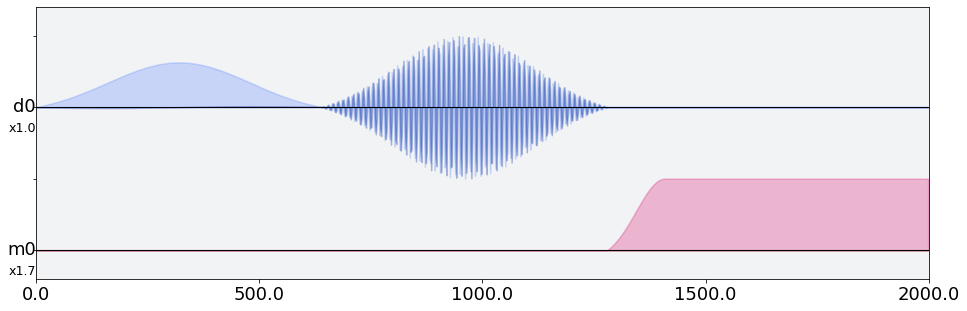

In [17]:
schedules[73].draw(plot_range=[0, 2000], style=style, channels=[DriveChannel(0), MeasureChannel(0)])

In [18]:
qobj = assemble(schedules, backend, meas_level=1, 
                meas_return=MeasReturnType.AVERAGE,
                shots=1024)

In [19]:
job = backend.run(qobj)
job.job_id()

'5e87323e39d24800186455ad'

In [20]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [21]:
def amp_func(x, a, b, c):
    """Function used to fit the amplitude scan."""
    return a*np.cos(np.pi*x/b)+c

In [22]:
signal = np.real(np.array(get_job_data(job, True, 0, 1e-15)))

popt, pcov = curve_fit(amp_func, xp12_scales, signal, [0.8, 2.0, 0.5])
xp12_scale = abs(popt[1])

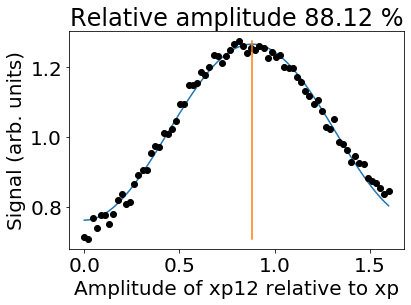

In [23]:
fig = plt.figure()
plt.plot(xp12_scales, amp_func(xp12_scales, *popt))
plt.plot(xp12_scales, signal, 'ok')
plt.plot([xp12_scale]*2, [min(signal), max(signal)])
plt.xlabel('Amplitude of xp12 relative to xp')
plt.ylabel('Signal (arb. units)')
plt.title('Relative amplitude %.2f %%' % (xp12_scale*100));

## Create a 0, 1, 2 discriminator with Qiskit Ignis

We should now have a calibrated $\pi$-pulse between the $|1\rangle$ and $|2\rangle$ states.
We check this by preparing calibration schedules to see if we can distinguish between the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states in the IQ plane.
This measurement is then used to build a 012 discriminator with Qiskit-Ignis.

In [24]:
# The measurement pulse may not be setup to distinguish between 0, 1, and 2
# This line of code allows us to adjust the frequency and amplitude
# of the measurement pulse
meas = measure_all(backend).instructions[1][1].pulse
meas_freq_shift = 0.075e6
meas_pulse = add_modulation(meas, meas_freq_shift, dt, scale=0.9)

meas_sched = Schedule(name='meas %f' % meas_freq_shift)
meas_sched += Play(meas_pulse, MeasureChannel(0))
meas_sched += Acquire(len(meas.samples), AcquireChannel(0), MemorySlot(0))

schedules = []

cal0 = Schedule(name='cal_0'.format(amp))
cal0 += meas_sched << cal0.duration
schedules.append(cal0)

cal1 = Schedule(name='cal_1'.format(amp))
cal1 += Play(xp, d0)
cal1 += meas_sched << cal1.duration
schedules.append(cal1)

# Create the calibrated pi-pulse between |1> and |2>
xp12 = add_modulation(xp, anharmonicity, dt, scale=xp12_scale)

cal2 = Schedule(name='cal_2'.format(amp))
cal2 += Play(xp, d0)
cal2 += Play(xp12, d0)
cal2 += meas_sched << cal2.duration
schedules.append(cal2)

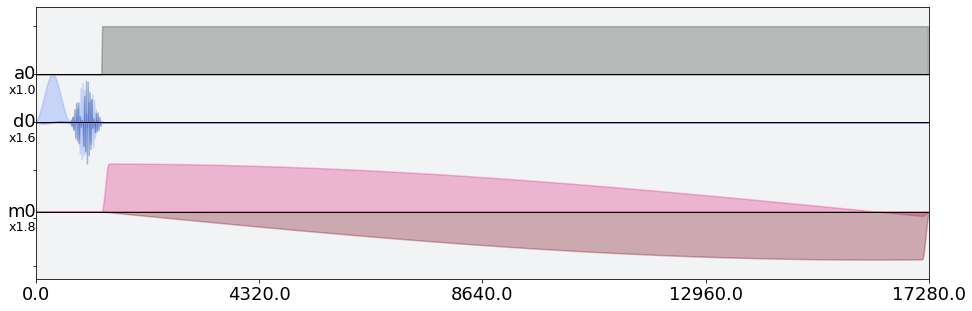

In [25]:
schedules[2].draw(style=style, channels=[DriveChannel(0), MeasureChannel(0), AcquireChannel(0)])

In [26]:
qobj = assemble(schedules, backend, meas_level=1, 
                meas_return=MeasReturnType.SINGLE,
                shots=1024)

In [27]:
job = backend.run(qobj)
job.job_id()

'5e87339475c0030019035438'

In [28]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [29]:
cal_result_disc = job.result(timeout=3600)

In [30]:
svc = SVC(C=0.01, kernel="rbf", gamma="scale")

svc_discriminator = SklearnIQDiscriminator(svc, cal_result_disc, [0], ['0', '1', '2'])
filter012 = DiscriminationFilter(svc_discriminator)

The data in the figure below should show three clearly seperated clusters in the IQ plan which correspond to $|0\rangle$, $|1\rangle$, and $|2\rangle$. Since the discriminator must discriminate three states we use the support vector machine provided by Scikit learn.

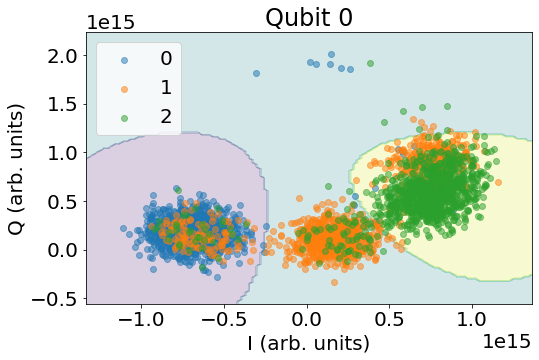

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
svc_discriminator.plot(ax, flag_misclassified=False, show_boundary=True);

This measurement can also be used to correct for readout errors using a readout error mitigation tools provided by Qiskit Ignis. Note that in the code below the discriminator returns the states encode in binary, therefore 0, 1, and 2 are represented by the strings '0', '1', and '10', respectively.

In [32]:
cal_counts = filter012.apply(cal_result_disc).get_counts()
cal_matrix = np.array([[cal_counts[0]['0'], cal_counts[1]['0'], cal_counts[2]['0']],
                      [cal_counts[0]['1'], cal_counts[1]['1'], cal_counts[2]['1']],
                      [cal_counts[0]['10'], cal_counts[1]['10'], cal_counts[2]['10']]])/shots
meas_filter = MeasurementFilter(cal_matrix, ['0', '1', '10'])

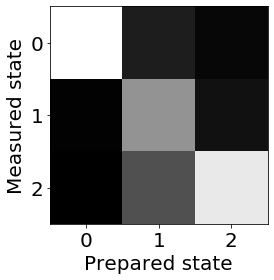

In [33]:
plt.imshow(cal_matrix, cmap='gray')
plt.xlabel('Prepared state')
plt.ylabel('Measured state');

## Geometric single-qubit gates

We now have all the tools needed to implement a single-qubit geometric gate between the $|0\rangle$ and $|2\rangle$ states. This is done by *simultaneously* applying the 2$\pi$-pulses between the $|0\rangle$ and $|1\rangle$ states and the 2$\pi$-pulses between the $|1\rangle$ and $|2\rangle$ states. We will save ourselves the task of calibrating the $2\pi$-pulses by using two back-to-back $\pi$-pulses. The pulses that we therefore need to implement have the envelope

\begin{align}
a\,\Omega(t)+b\,\eta\,\Omega(t)\,e^{i\alpha t}.
\end{align}

The complex scalars $a$ and $b$ define the rotation angle $\theta$ and phase $\phi$ of the unitary gate that will be implemented on the Bloch sphere created by $|0\rangle$ and $|2\rangle$. $\theta$ and $\phi$ are related to $a$ and $b$ by

\begin{align}
e^{i\phi}\tan\frac{\theta}{2}=\frac{a}{b}.
\end{align}

Note that the pulses that create the single-qubit geometric gate cannot be implement with the `SetFrequency` instruction.

In [34]:
def geometric(a: complex, b: complex, xp: SamplePulse, xp12: SamplePulse) -> Schedule:
    """
    Create a single-qubit geometric gate between the 0 and 2 state.
    In principle the geometric gate is built from a 2pi rotation between 0 and
    1 and a 2pi rotation between 1 and 2. Since we have not calibrated the 2pi
    rotations we will emulate them with two pi back-to-back pi rotations.
    
    The geometric gate creates a rotation on the Bloch Sphere between |0> and |2>.
    The rotation angle theta and phase phi on the (0,2) Bloch sphere are
    given by e^(i*phi)*tan(theta/2)=a/b.
    
    Args:
        a: Parameter to control the geometric rotation.
        b: Parameter to control the geometric rotation.
        xp: Calibrated X gate between |0> and |1>.
        xp12: Calibrated X gate between |1> and |2>.
        
    Returns: A schedules with the geometric gate.
    """
    
    if abs(abs(a)**2 + abs(b)**2 - 1.0) > 1e-4:
        raise ValueError('a and b must satisfy |a|**2+|b|**2')
                
    geom_samples = a*xp.samples + b*xp12.samples
    geom = SamplePulse(geom_samples)
    
    sched = Schedule(name='Geometric (%f, %f) ' % (b, b))
    sched += Play(geom, d0)
    sched += Play(geom, d0)
    sched += meas_sched << sched.duration
    
    return sched

In [35]:
schedules = [cal0, cal1, cal2]
angles = np.linspace(0., np.pi, 70)
for angle in angles:
    a = np.sin(angle/2)    
    schedules.append(geometric(a, np.sqrt(1.0-a*a), xp, xp12))

The schedule below shows the single-qubit geometric gate, implemented as two back-to-back superpositions of xp and xp12. These pulses can only be implemented on high resolution devices and cannot be implemented with the `SetFrequency` instruction.

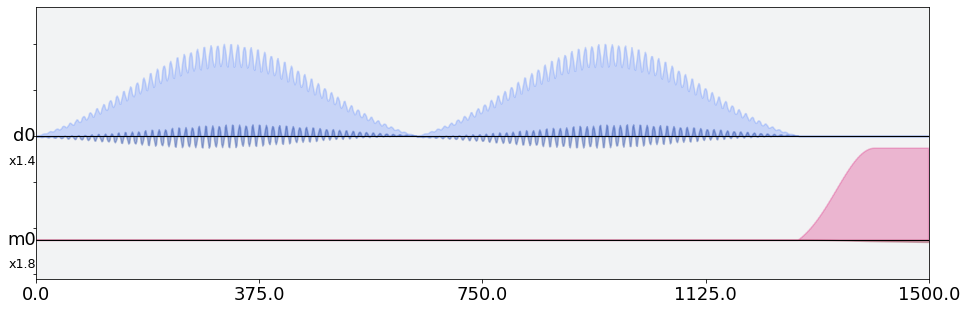

In [36]:
schedules[65].draw(plot_range=[0, 1500], style=style, channels=[d0, MeasureChannel(0)])

In [37]:
qobj = assemble(schedules, backend, meas_level=1, 
                meas_return=MeasReturnType.SINGLE,
                shots=1024)

In [38]:
job = backend.run(qobj)
job.job_id()

'5e8733fc75c003001903543c'

In [39]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [40]:
geom_result = job.result(timeout=3600)

To analyse the data we first apply the the 012 discriminator that we build with Qiskit-Ignis. Next, we employ our measurement error mitigation filter to correct the readout.

In [41]:
# Apply discriminator
geom_discriminated = filter012.apply(geom_result)

# Mitigate readout errors
geom_mitigated = meas_filter.apply(geom_discriminated)

# Compute the population counts
counts = geom_mitigated.get_counts()
pop0 = [cnt.get('0',0)/1024 for cnt in counts[3:]]
pop1 = [cnt.get('1',0)/1024 for cnt in counts[3:]]
pop2 = [cnt.get('10',0)/1024 for cnt in counts[3:]]

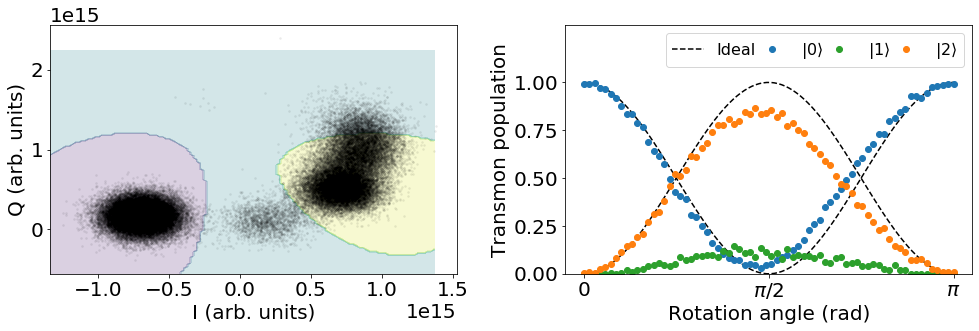

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(14,5), tight_layout=True)

svc_discriminator.plot(ax[0], flag_misclassified=False, show_boundary=True, show_fitting_data=False);
for idx in range(len(angles)):
    iqs = geom_result.get_memory(idx+3)
    ax[0].scatter(np.real(iqs), np.imag(iqs), s=3, color='k',alpha=0.05)

ax[0].set_title('')

ax[1].plot(np.linspace(0, np.pi, 100), np.cos(np.linspace(0, np.pi, 100))**2, '--k')
ax[1].plot(np.linspace(0, np.pi, 100), np.sin(np.linspace(0, np.pi, 100))**2, '--k', label='Ideal')
ax[1].plot(angles, pop0, 'oC0', label='$|0\\rangle$')
ax[1].plot(angles, pop1, 'oC2', label='$|1\\rangle$')
ax[1].plot(angles, pop2, 'oC1', label='$|2\\rangle$')
ax[1].set_xlabel('Rotation angle (rad)')
ax[1].set_ylabel('Transmon population')
ax[1].set_xticks([0, np.pi/2, np.pi])
ax[1].set_xticklabels(['0', '$\pi/2$', '$\pi$'])
ax[1].set_ylim([0, 1.3])
ax[1].set_yticks([0, 0.25, 0.50, 0.75, 1.0])
ax[1].legend(ncol=4, loc=1, fontsize=16, columnspacing=0);

The plot above shows the population in the transmon after the single-qubit geometric gate for different rotation angles $\theta$.
As can be seen from the plot the gate leaves some population in the $|1\rangle$ state.
This should not be the case and is most likely a result of $T_1$-decay, measurement errors, and the simple calibration procedure employed which may yield an imperfect $\pi$-pulse between the $|1\rangle$ and $|2\rangle$ states.

In [43]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright